https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

# 导入库

In [59]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB


# 获取数据

In [60]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# 数据探索/分析

In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


训练集有 891 个示例和 11 个特征 + 目标变量 (survived)。其中 2 个特征是浮点数，5 个是整数，5 个是对象。下面我列出了带有简短说明的功能：

survival:    生存
PassengerId: 乘客的唯一 ID。

pclass:    票务类    
sex:    性别      
Age:    年龄    
sibsp:    兄弟姐妹/配偶登船的     
parch:    家长/儿童登船的     
ticket:    票号    
fare:    票价     
cabin:    客舱号  
embarked:    登船港

In [62]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


上面我们可以看到，训练集中的 38% 在泰坦尼克号上幸存下来。我们还可以看到乘客的年龄范围从 0.4 到 80。除此之外，我们已经可以检测到一些包含缺失值的特征，例如“年龄”特征。

In [63]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


从上表中，我们可以注意到一些事情。首先，我们稍后需要将很多特征转换为数字特征，以便机器学习算法可以处理它们。此外，我们可以看到特征有很大不同的范围，我们需要将其转换为大致相同的比例。我们还可以发现更多的特征，其中包含我们需要处理的缺失值（NaN = 不是数字）。
让我们更详细地看看实际上缺少哪些数据：

In [64]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


Embarked 特征只有 2 个缺失值，可以轻松填充。处理具有 177 个缺失值的“年龄”功能会更加棘手。“Cabin”功能需要进一步调查，但看起来我们可能希望将其从数据集中删除，因为其中 77% 已丢失。

In [65]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

在上面你可以看到 11 个特征 + 目标变量（survived）。哪些特征可以促成高存活率？
对我来说，如果除了“PassengerId”、“Ticket”和“Name”之外的所有内容都与高存活率相关，那将是有意义的。

1. 年龄和性别：

C:\Users\elvis\Envs\sklearn\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


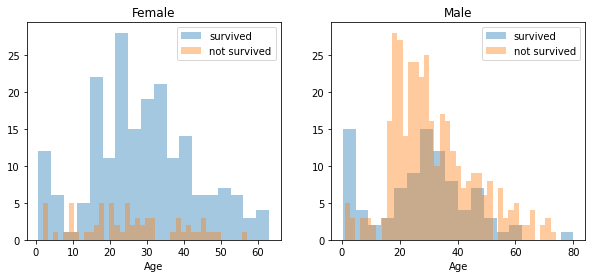

In [66]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

可以看到，男性在18-30岁的时候存活的概率很高，女性也有一点，但不完全是这样。对于女性来说，14 到 40 岁之间的生存机会更高。
对于男性来说，在 5 到 18 岁之间存活的概率非常低，但对于女性来说则不然。另一件需要注意的是，婴儿的存活概率也稍高一些。
由于似乎存在某些年龄，这增加了生存的几率，并且因为我希望每个特征的比例大致相同，所以我稍后将创建年龄组。
3. Embarked（登船港）, Pclass（票务类） and Sex:

C:\Users\elvis\Envs\sklearn\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


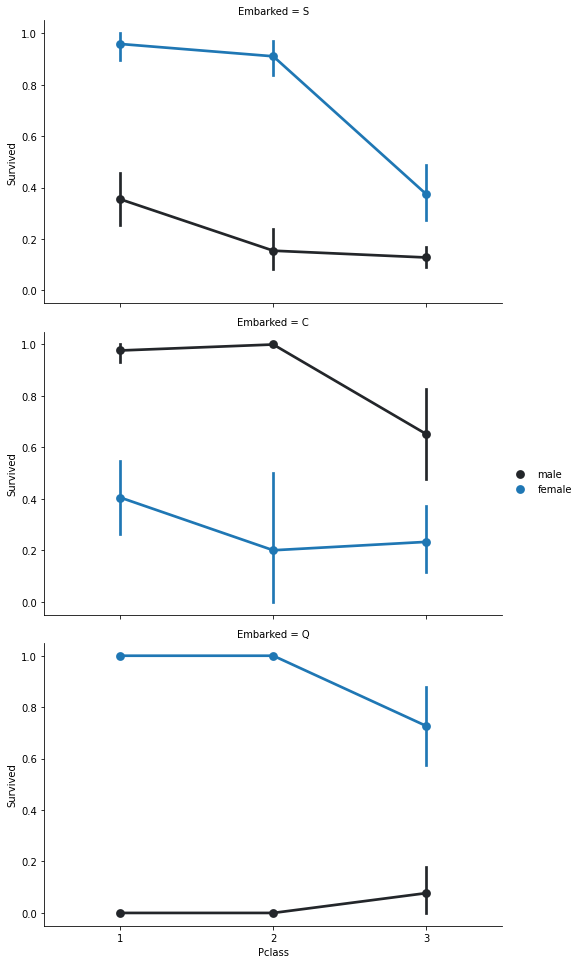

In [67]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

根据性别，登船港似乎与生存相关。
Q 港和 S 港的女性有更高的生存机会。如果他们在 C 端口，则反之亦然。 如果他们在 C 端口，则男人的生存概率很高，但如果他们在 Q 或 S 端口，则生存概率较低。
Pclass （票务类）似乎也与生存相关。我们将在下面生成它的另一个图。

4. Pclass:

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

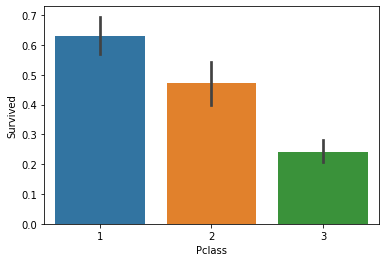

In [68]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

在这里我们可以清楚地看到，Pclass 正在为一个人的生存机会做出贡献，特别是如果这个人在 class 1 中。我们将在下面创建另一个 pclass 图。

C:\Users\elvis\Envs\sklearn\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


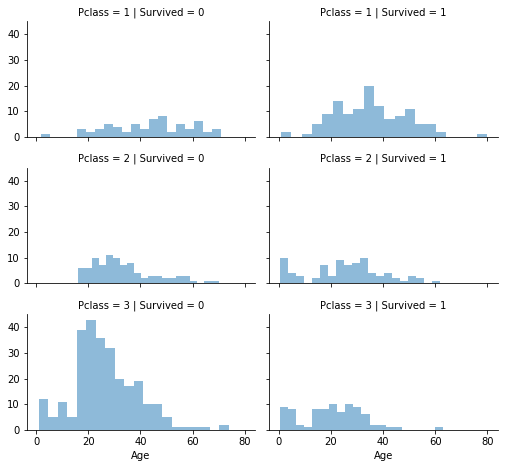

In [69]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6) 
grid.map(plt.hist, 'Age', alpha=.5, bins=20) 
grid .add_legend();

上图证实了我们对 pclass 1 的假设，但我们也可以发现 pclass 3 中的人很可能无法生存。

5. SibSp（兄弟姐妹/配偶登船的） 和 Parch（家长/儿童登船的）：
SibSp 和 Parch 作为一个组合特征会更有意义，它显示了一个人在泰坦尼克号上的亲属总数。我将在下面创建它，还有一个功能，显示这些人是否独自一人。

In [70]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

C:\Users\elvis\Envs\sklearn\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\elvis\Envs\sklearn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


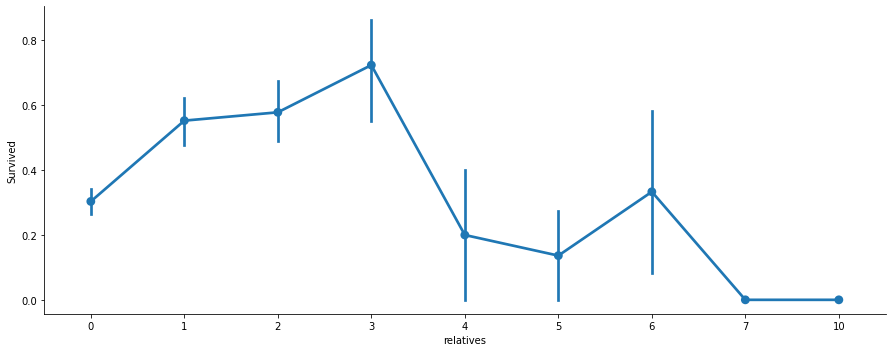

In [71]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

在这里我们可以看到，您有 1 到 3 个亲属的生存概率很高，但如果您的亲属少于 1 个或超过 3 个，则生存概率较低（某些情况下有 6 个亲属除外）。

# 数据预处理

首先，我将从训练集中删除 'PassengerId'，因为它对一个人的生存概率没有贡献。我不会将它从测试集中删除，因为提交时需要它。

In [72]:
train_df = train_df.drop(['PassengerId'],axis=1)

## 缺失数据：

### Cabin（客舱号）：
提醒一下，我们必须处理 Cabin (687)、Embarked (2) 和 Age (177)。首先我想，我们必须删除“Cabin”变量，但后来我发现了一些有趣的事情。客舱编号看起来像“C123”，字母指的是甲板。因此，我们将提取这些并创建一个包含人物牌组的新特征。之后我们会将特征转换为数值变量。缺失值将被转换为零。在下图中，您可以看到泰坦尼克号的实际甲板，范围从 A 到 G。

In [73]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

### 年龄：
现在我们可以解决年龄特征缺失值的问题。我将创建一个包含随机数的数组，这些随机数是根据与标准偏差和 is_null 相关的平均年龄值计算得出的。

In [74]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()


0

Embarked （登船）：
由于 Embarked 特征只有 2 个缺失值，我们将只用最常见的一个来填充它们。

In [75]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [76]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

## 转换特征：

In [77]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Name       891 non-null    object 
 3   Sex        891 non-null    object 
 4   Age        891 non-null    int32  
 5   SibSp      891 non-null    int64  
 6   Parch      891 non-null    int64  
 7   Ticket     891 non-null    object 
 8   Fare       891 non-null    float64
 9   Embarked   891 non-null    object 
 10  relatives  891 non-null    int64  
 11  not_alone  891 non-null    int32  
 12  Deck       891 non-null    int32  
dtypes: float64(1), int32(3), int64(5), object(4)
memory usage: 80.2+ KB


在上面你可以看到“票价”是一个浮点数，我们必须处理 4 个分类特征：姓名、性别、票务和登船。让我们一个接一个地调查和转换。

### Fare（票价）：
将“Fare”从 float 转换为 int64，使用 pandas 提供的“astype()”函数：

In [78]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

### Name：
我们将使用Name特征从Name数据中提取头衔，以便我们可以从中构建一个新特征。

In [79]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

### 性别：
将“性别”特征转换为数字。

In [80]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

### Ticket:

In [81]:
train_df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

由于Ticket 属性有681 个唯一的票证，将它们转换为有用的类别会有点棘手。所以我们将从数据集中删除它。

In [82]:
train_df = train_df.drop(['Ticket'],axis=1) 
test_df = test_df.drop(['Ticket'],axis=1)

### Embarked：
将“Embarked”特征转换为数字。

In [83]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

# 创建类别：
我们现在将在以下功能中创建类别：

## 年龄：
现在我们需要转换“年龄”特征。首先，我们将把它从浮点数转换成整数。然后我们将创建新的“AgeGroup”变量，将每个年龄归为一个组。请注意，重要的是要注意如何形成这些组，因为例如您不希望 80% 的数据属于组 1。

In [84]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed

train_df['Age'].value_counts()

4    164
6    163
5    141
3    139
2    123
1     93
0     68
Name: Age, dtype: int64

票价：
对于“票价”特征，我们需要做与“年龄”特征相同的操作。但这并不容易，因为如果我们将票价值的范围划分为几个同样大的类别，那么 80% 的值会落入第一类。幸运的是，我们可以使用 sklearn “qcut()”函数，我们可以使用它来查看如何形成类别。

In [89]:
pd.qcut(train_df['Fare'], 6).value_counts()

(-0.001, 7.0]    241
(14.0, 26.0]     165
(8.0, 14.0]      146
(52.0, 512.0]    146
(26.0, 52.0]     123
(7.0, 8.0]        70
Name: Fare, dtype: int64

In [90]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# 创建新特征

我将向数据集添加两个新特征，这些特征是我从其他特征中计算出来的。

## 1. 年龄乘以票务类

In [91]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

## 2. 人均票价

In [92]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
    
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,3,1,1,0,3,3,5,1
2,1,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,3,0,1,0,3,3,5,1
4,0,3,0,5,0,0,1,0,0,1,8,1,15,1
5,0,3,0,4,0,0,1,2,0,1,8,1,12,1
6,0,1,0,6,0,0,3,0,0,1,5,1,6,3
7,0,3,0,0,3,1,2,0,4,0,8,4,0,0
8,1,3,1,3,0,2,1,0,2,0,8,3,9,0
9,1,2,1,1,1,0,2,1,1,0,8,3,2,1


# 构建机器学习模型

现在我们将训练几个机器学习模型并比较它们的结果。请注意，由于数据集不为其测试集提供标签，因此我们需要使用对训练集的预测来相互比较算法。稍后，我们将使用交叉验证。

In [93]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()